In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
import netCDF4
import xarray as xr

import xarray.plot as xplt
#import sunpy.timeseries as ts 

########## for cycle ##############
from matplotlib import dates as d
import datetime as dt
import time

from functools import reduce

In [4]:
# define function for converting dataset to time series

def netcdf_to_df(ds, lon, lat):
    #ds_MaunaKea=  ds.sel(longitude=204.53,latitude= 19.83,method='nearest')
    ds_MaunaKea=  ds.sel(longitude=lon,latitude= lat,method='nearest')
    df = ds_MaunaKea.to_dask_dataframe()
    return(df)

In [5]:
# prepare CFHT observational data for merging
def mes_prep(CFHT_hourly, parameter = None):
    CFHT_hourly = CFHT_hourly.rename(columns={'Unnamed: 0': 'time'})
    # change the format of the times column to datetime format
    CFHT_hourly['time'] = pd.to_datetime(CFHT_hourly['time']) 

    #check the format
    print(CFHT_hourly['time'].dtype)
    #print(CFHT_hourly['time'][0])

    #from HST to UTC (+10 hours)
    CFHT_hourly['time'] = CFHT_hourly['time'] + dt.timedelta(hours=10)
    
    #set index 
    CFHT_hourly.set_index('time', inplace=True)
    
    if parameter == 'temperature(C)':
        #filter out values exactly equal to 0, smaller than -100°C and greater than 30°C (years 1991 and 1992)
        mask_T = (CFHT_hourly['temperature(C)'] != 0) & (CFHT_hourly['temperature(C)'] > -100) & (CFHT_hourly['temperature(C)'] < 50)
        print('masked')
        CFHT_hourly = CFHT_hourly[mask_T]
        
    elif parameter == 'relative_humidity(%)':
        mask_RH = (CFHT_hourly['relative_humidity(%)'] <= 100) & (CFHT_hourly['relative_humidity(%)'] > 0) & (CFHT_hourly['relative_humidity(%)'] != 'nan')
        CFHT_hourly = CFHT_hourly[mask_RH]
    
    elif parameter == 'pressure (mb)':
        mymean = np.mean(CFHT_hourly['pressure (mb)'])
        mask_P = (CFHT_hourly['pressure (mb)'] <= (mymean + 20)) & (CFHT_hourly['pressure (mb)'] >= (mymean - 20)) 
        CFHT_hourly = CFHT_hourly[mask_P]
    
    # create a new column consisting of the cycle parameter of the correspondend entry
    #for seasonal cycle (12 months), create column with "months"
    CFHT_hourly['months'] = pd.DatetimeIndex(CFHT_hourly.index).month                                            

    #for diurnal cycle (24 hours), create column with "hours"
    CFHT_hourly['hours'] = pd.DatetimeIndex(CFHT_hourly.index).hour

    # for monthly timeseries, create column with "YYYY-MM"
    CFHT_hourly['YYYY_MM'] = CFHT_hourly.index.strftime('%Y-%m')

    # for 1 year averages, create column with years
    CFHT_hourly['years'] = pd.DatetimeIndex(CFHT_hourly.index).year
    
    return(CFHT_hourly)

In [6]:
# merge datasets to only compare equal rows of data
def merge_df(*args):
    df_list = []
    for ar in args: 
        df_list.append(ar)
    df_merged = reduce(lambda left, right: pd.merge(left, right, left_on='time', right_on='time', how='outer'), df_list)

    # delete rows containing NaN
    df_merged_nonan = df_merged.dropna(axis='rows', how='any', thresh=None, subset=None, inplace=False)

    # reduce to seasonal cycle
    seasonal_cycle = df_merged_nonan.groupby('months').describe()

    # reduce to seasonal cycle
    diurnal_cycle = df_merged_nonan.groupby('hours').describe()
    
    # for monthly timeseries, groupby YYYY-MM
    monthly_grouped = df_merged_nonan.groupby('YYYY_MM').describe()

    # for yearly timeseries, group by 'years'
    yearly_grouped = df_merged_nonan.groupby('years').describe()
    
    return df_merged_nonan, seasonal_cycle, diurnal_cycle, monthly_grouped, yearly_grouped

In [7]:
def df_prep(df, parameter, colname):
    df = df.drop('longitude', axis=1)
    df= df.drop('latitude', axis=1)
    df = df.set_index('time')
    df = df.rename(columns={parameter: colname})#colname = 'r_700'
    df_comp= df.compute()
    
    return(df_comp)

In [8]:
# plot seasonal cycle observational data and also show quartiles
from itertools import cycle


#CFHT_parameter = 'temperature(C)'
# key = 't_600'
def plot_cycle(cycle_name, cycle_string,  CFHT_parameter, filename, *args):
    cycol = cycle('rgbcm')
    plt.plot(cycle_name.index, cycle_name[CFHT_parameter]['mean'], '-ko', linewidth=2.0, 
            label = 'CFHT')
    plt.plot(cycle_name.index, cycle_name[CFHT_parameter]['75%'], color='k')
    plt.plot(cycle_name.index, cycle_name[CFHT_parameter]['25%'], color='k')
    plt.fill_between(cycle_name.index, cycle_name[CFHT_parameter]['mean'], cycle_name[CFHT_parameter]['75%'],
                     alpha=.5, facecolor='k', label = 'CFHT 25 to 75 percentile')
    plt.fill_between(cycle_name.index, cycle_name[CFHT_parameter]['mean'], cycle_name[CFHT_parameter]['25%'], 
                     alpha=.5, facecolor='k')
    for ar in args: 
        my_col =next(cycol)
        plt.plot(cycle_name.index, cycle_name[ar]['mean'], '-o', c= my_col, linewidth=2.0, 
            label = 'Era5 ' + ar)

        plt.plot(cycle_name.index, cycle_name[ar]['75%'], color=my_col)
        plt.plot(cycle_name.index, cycle_name[ar]['25%'], color=my_col)
        plt.fill_between(cycle_name.index, cycle_name[ar]['mean'], cycle_name[ar]['75%'], 
                         alpha=.5, facecolor=my_col, label = 'Era5 ' + ar + ' 25 to 75 percentile')
        plt.fill_between(cycle_name.index, cycle_name[ar]['mean'], cycle_name[ar]['25%'], 
                         alpha=.5, facecolor=my_col)

    #plt.plot(diurnal_cycle.index, diurnal_cycle['r_750']['mean'], '-go', linewidth=2.0, 
    #        label = 'Era5, 750hPa')
    plt.legend()
    #plt.ylim(0, 100)
    
    if 'diurnal cycle' in cycle_string:
        plt.xticks(np.arange(0, 24, step=1))
        plt.xlabel('time [h]')
        plt.xlim(0, 24)
    elif 'seasonal cycle' in cycle_string:
        plt.xlabel('time [months]')
        plt.xlim(1, 12)
        
    if CFHT_parameter == 'relative_humidity(%)':
        plt.ylim(0, 100)
        plt.ylabel('Relative humidity [%]')
    
    elif CFHT_parameter == 'specific_humidity':
        plt.ylabel('Specific humidity [kg/kg]')
    #    plt.ylim(0,0.05)
    
    elif CFHT_parameter == 'temperature(C)':
    #    plt.ylim(0,20)
        plt.ylabel('Temperature [°C]')
 
    # add surface pressure in another subplot
    
    plt.title(cycle_string)
    fig1 = plt.gcf()
    ax = plt.subplot(111)
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig1.savefig(filename) #'diurnal_cycle_T_2008to2012.pdf'
    plt.show()

############################ relative humidity ###################

In [2]:
import os

os.getcwd()

'/home/haslebacher/chaldene/Astroclimate_Project/sites/MaunaKea/Code'

In [3]:
# change current working directory
os.chdir('/home/haslebacher/chaldene/Astroclimate_Project')
# open NETCDF files on 600hPa to 750hPa

ds_RH_600 = xr.open_dataset('home/caroline/chaldene/Astroclimate_Project/sites/MaunaKea/Data/Era_5/RH/Era5_Mauna_Kea_1979_relative_humidity_600.nc')
# open observational data from CFHT for Mauna Kea

CFHT_RH_hourly = pd.read_csv('./sites/MaunaKea/Data/in-situ/RH/downsampled_masked_RH_1991to2018_hourly_means.csv')#/home/caroline/chaldene/Astroclimate_Project/sites/MaunaKea/Data/in-situ/RH/


NameError: name 'os' is not defined

In [5]:
CFHT_RH_hourly

,Unnamed: 0,relative_humidity(%)
0,1992-03-13 21:00:00,15.600000
1,1992-03-13 22:00:00,13.938333
2,1992-03-13 23:00:00,14.846667
3,1992-03-14 00:00:00,14.905000
4,1992-03-14 01:00:00,NaN
...,...,...
264784,2020-01-16 22:00:00,98.466667
264785,2020-01-16 23:00:00,96.383333
264786,2020-01-17 00:00:00,98.433333
264787,2020-01-17 01:00:00,98.350000


In [12]:
#open NETCDF files on different pressure levels for "relative humidity"
#ds_RH_600_mf = xr.open_mfdataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/RH/*.nc', combine = 'by_coords')
ds_RH_600 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/RH/Era5_2008to2012_RH_600hPa.nc')
ds_RH_650 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/RH/Era5_2008to2012_RH_650hPa.nc')
#ds_RH_700 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/RH/Era5_2008to2012_RH_700hPa.nc')
#ds_RH_750 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/RH/Era5_2008to2012_RH_750hPa.nc')

#observational data from MaunaKea (CFHT)
CFHT_RH_hourly = pd.read_csv('/home/caroline/Dropbox/Astroclimate Project/Mauna_Kea/CFHT/pressure_levels_600to750hPa/RH/R/downsampled_masked_RH_1991to2018_hourly_means.csv')

In [13]:
ds_RH_600

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 43848)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2008-01-01 ... 2012-12-31T23:00:00
Data variables:
    r          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-02-25 16:09:40 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [14]:
df_RH_600 = netcdf_to_df(ds_RH_600, 204.5, 19.75)
print('600done')
df_RH_650 = netcdf_to_df(ds_RH_650, 204.5, 19.75)
print('650done')
#df_RH_700 = netcdf_to_df(ds_RH_700)
#print('700done')
#df_RH_750 = netcdf_to_df(ds_RH_750)
#print('750done')

600done
650done


In [16]:
df_RH_600.compute()


,time,longitude,latitude,r
0,2008-01-01 00:00:00,204.5,19.75,96.182327
1,2008-01-01 01:00:00,204.5,19.75,95.629868
2,2008-01-01 02:00:00,204.5,19.75,95.620758
3,2008-01-01 03:00:00,204.5,19.75,92.063179
4,2008-01-01 04:00:00,204.5,19.75,89.907990
...,...,...,...,...
43843,2012-12-31 19:00:00,204.5,19.75,4.671738
43844,2012-12-31 20:00:00,204.5,19.75,4.222488
43845,2012-12-31 21:00:00,204.5,19.75,4.158745
43846,2012-12-31 22:00:00,204.5,19.75,5.427574


In [21]:
CFHT_RH_hourly_preped = mes_prep(CFHT_RH_hourly)
df_prep_RH_600 = df_prep(df_RH_600, 'r', 'r_600')
df_prep_RH_650 = df_prep(df_RH_650, 'r', 'r_650')
#df_prep_RH_700 = df_prep(df_RH_700, 'r', 'r_700')
#df_prep_RH_750 = df_prep(df_RH_750, 'r', 'r_750')

datetime64[ns]
                      time  relative_humidity(%)
0      1992-03-13 21:00:00             15.600000
1      1992-03-13 22:00:00             13.938333
2      1992-03-13 23:00:00             14.846667
3      1992-03-14 00:00:00             14.905000
4      1992-03-14 01:00:00                   NaN
...                    ...                   ...
264784 2020-01-16 22:00:00             98.466667
264785 2020-01-16 23:00:00             96.383333
264786 2020-01-17 00:00:00             98.433333
264787 2020-01-17 01:00:00             98.350000
264788 2020-01-17 02:00:00             94.535714

[264789 rows x 2 columns]
                      time  relative_humidity(%)
0      1992-03-14 07:00:00             15.600000
1      1992-03-14 08:00:00             13.938333
2      1992-03-14 09:00:00             14.846667
3      1992-03-14 10:00:00             14.905000
4      1992-03-14 11:00:00                   NaN
...                    ...                   ...
264784 2020-01-17 08:00:00 

In [23]:
seasonal_cycle_RH, diurnal_cycle_RH = merge_df(CFHT_RH_hourly_preped, df_prep_RH_600, df_prep_RH_650)

In [97]:
diurnal_cycle_RH

relative_humidity(%)                                             \
                     count       mean        std       min        25%   
hours                                                                   
0.0                 1757.0  30.601190  28.039555  1.000000   9.833333   
1.0                 1755.0  30.632207  28.204023  1.000000   9.683333   
2.0                 1752.0  30.544979  28.292527  1.000000   9.762500   
3.0                 1752.0  30.637407  28.421928  1.000000   9.750000   
4.0                 1752.0  30.494925  28.284809  1.000000   9.762500   
5.0                 1748.0  30.364066  28.260700  1.000000   9.700000   
6.0                 1750.0  29.662407  27.666527  1.000000   9.750000   
7.0                 1753.0  28.803287  27.102986  1.000000   9.550000   
8.0                 1756.0  28.453680  26.563500  1.333333   9.829167   
9.0                 1758.0  28.655075  25.891944  1.500000  10.370833   
10.0                1757.0  29.817762  25.433679  1.750000  11.333333   
11.0                1757.0  31.900521  25.607356  2.000000  12.583333   
12.0                1757.0  34.364102  26.166874  2.333333  13.650000   
13.0                1755.0  35.954461  26.725541  2.916667  14.000000   
14.0                1756.0  36.686162  27.457712  2.833333  14.250000   
15.0                1758.0  36.277013  28.024787  2.666667  13.587500   
16.0                1757.0  35.003390  28.192478  2.583333  12.533333   
17.0                1756.0  34.121999  28.377594  2.166667  11.970833   
18.0                1759.0  33.139214  28.486213  2.000000  10.991667   
19.0                1760.0  32.571787  28.520773  1.666667  10.416667   
20.0                1759.0  31.546153  28.245899  1.666667  10.166667   
21.0                1759.0  31.069195  27.869743  1.500000  10.166667   
22.0                1759.0  30.652367  27.934630  2.000000  10.066667   
23.0                1760.0  30.718857  28.150826  1.250000   9.912500   

                                    months            ...      r_700  \
             50%        75%    max   count      mean  ...        75%   
hours                                                 ...              
0.0    18.583333  42.700000  100.0  1757.0  6.379624  ...  76.252609   
1.0    18.150000  43.541667  100.0  1755.0  6.378917  ...  80.068684   
2.0    18.000000  42.312500  100.0  1752.0  6.377283  ...  82.046511   
3.0    18.083333  43.725000  100.0  1752.0  6.377283  ...  82.580116   
4.0    18.066667  43.570833  100.0  1752.0  6.377854  ...  80.688242   
5.0    18.016667  42.050000  100.0  1748.0  6.376430  ...  74.606691   
6.0    17.583333  40.500000  100.0  1750.0  6.381143  ...  67.931963   
7.0    17.000000  38.083333  100.0  1753.0  6.382202  ...  61.689560   
8.0    16.950000  38.012500  100.0  1756.0  6.378132  ...  56.570535   
9.0    17.825000  38.241667  100.0  1758.0  6.377133  ...  52.593609   
10.0   19.916667  39.050000  100.0  1757.0  6.378486  ...  55.221630   
11.0   22.433333  42.716667  100.0  1757.0  6.380194  ...  52.923817   
12.0   25.133333  49.750000  100.0  1757.0  6.376209  ...  52.069366   
13.0   26.916667  52.416667  100.0  1755.0  6.374929  ...  51.123007   
14.0   27.025000  53.308333  100.0  1756.0  6.377563  ...  51.096624   
15.0   26.250000  53.358333  100.0  1758.0  6.382253  ...  50.415792   
16.0   24.583333  50.716667  100.0  1757.0  6.379624  ...  49.410709   
17.0   23.066667  49.850000  100.0  1756.0  6.379841  ...  47.900107   
18.0   22.066667  47.075000  100.0  1759.0  6.379193  ...  48.779234   
19.0   21.400000  46.420833  100.0  1760.0  6.380114  ...  51.637037   
20.0   19.766667  45.283333  100.0  1759.0  6.378624  ...  54.871000   
21.0   19.216667  44.866667  100.0  1759.0  6.380330  ...  65.226494   
22.0   19.033333  42.741667  100.0  1759.0  6.378056  ...  69.260437   
23.0   18.533333  42.983333  100.0  1760.0  6.383523  ...  72.628868   

                    r_750                                              \
              ma

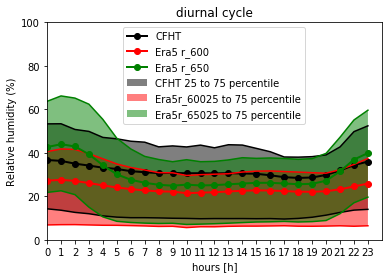

In [62]:
plot_cycle(diurnal_cycle_RH,'diurnal cycle', 'relative_humidity(%)', 'r',  'diurnal_cycle_UTC_RH_600hPa_650hPa_2008to2012.pdf', 'r_600', 'r_650')

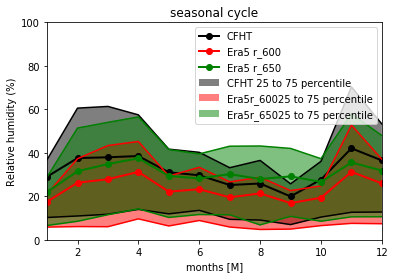

In [56]:
plot_cycle(seasonal_cycle_RH,'seasonal cycle MK, surface pressure = ', 'relative_humidity(%)', 'r',  'seasonal_cycle_UTC_RH_600hPa_650hPa_2008to2012.pdf', 'r_600', 'r_650')

################# Temperature ######################

In [7]:
#open NETCDF files for "temperature"
ds_T_600 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/T/Era5_2008to2012_T_600hPa.nc')
ds_T_2m = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/Era5_single_level_2008to2012_2mTemperature.nc')

#observational data from MaunaKea (CFHT)
CFHT_T_hourly = pd.read_csv('/home/caroline/Dropbox/Astroclimate Project/Mauna_Kea/CFHT/Temperature/downsampled_CFHT_T_1991to2018_hourly_means.csv')

In [8]:
ds_T_2m

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 43848)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2008-01-01 ... 2012-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-03 10:49:37 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [9]:

CFHT_T_hourly_preped = mes_prep(CFHT_T_hourly, 'temperature(C)')


datetime64[ns]
                      time  temperature(C)
0      1991-01-01 10:00:00        0.000000
1      1991-01-01 11:00:00        0.000000
2      1991-01-01 12:00:00        0.000000
3      1991-01-01 13:00:00        0.000000
4      1991-01-01 14:00:00        0.000000
...                    ...             ...
275793 2020-01-16 22:00:00       -0.508500
275794 2020-01-16 23:00:00       -0.339333
275795 2020-01-17 00:00:00       -0.553333
275796 2020-01-17 01:00:00       -0.439333
275797 2020-01-17 02:00:00       -0.804643

[275798 rows x 2 columns]
                      time  temperature(C)
0      1991-01-01 20:00:00        0.000000
1      1991-01-01 21:00:00        0.000000
2      1991-01-01 22:00:00        0.000000
3      1991-01-01 23:00:00        0.000000
4      1991-01-02 00:00:00        0.000000
...                    ...             ...
275793 2020-01-17 08:00:00       -0.508500
275794 2020-01-17 09:00:00       -0.339333
275795 2020-01-17 10:00:00       -0.553333
275796 2020-

In [10]:
# prepare dataframe Era 5, Mauna Kea
#df_T_600 = netcdf_to_df(ds_T_600, 204.5, 19.5) # Mauna Loa
#df_T_600 = netcdf_to_df(ds_T_600, 204.25, 20)
df_T_600 = netcdf_to_df(ds_T_600, 204.5, 19.75)
df_prep_T = df_prep(df_T_600, 't', 't_600')
df_prep_T_Celsius_600 = (df_prep_T['t_600']-273.15)

In [25]:
# prepare dataframe Era 5, Mauna Loa
df_T_600_ML = netcdf_to_df(ds_T_600, 204.5, 19.5)
df_prep_T_ML = df_prep(df_T_600_ML, 't', 't_600_ML')
df_prep_T_Celsius_600_ML = (df_prep_T_ML['t_600_ML']-273.15)

In [40]:
# prepare data from single level, 2m above surface temperature, Mauna Kea
#df_T_2m = netcdf_to_df(ds_T_2m, 204.5, 19.75)
df_prep_T_2m = df_prep(df_T_2m, 't', 't_2m')
df_prep_T_2m = df_prep_T_2m.rename(columns={'t2m': 't_2m'}) # does not seem to work in the function
df_prep_T_Celsius_2m = (df_prep_T_2m['t_2m']-273.15)

In [33]:
# prepare data from single level, 2m above surface temperature, Mauna Loa
#df_T_2m_ML = netcdf_to_df(ds_T_2m, 204.5, 19.5)
df_prep_T_2m_ML = df_prep(df_T_2m_ML, 't', 't_2m_ML')
df_prep_T_2m_ML = df_prep_T_2m_ML.rename(columns={'t2m': 't_2m_ML'}) # does not seem to work in the function
df_prep_T_Celsius_2m_ML = (df_prep_T_2m_ML['t_2m_ML']-273.15)

In [46]:
seasonal_cycle_T2, diurnal_cycle_T2 = merge_df(CFHT_T_hourly_preped, df_prep_T_Celsius_600, df_prep_T_Celsius_2m, df_prep_T_Celsius_600_ML, df_prep_T_Celsius_2m_ML)

In [47]:
diurnal_cycle_T2

temperature(C)                                                    \
               count      mean       std       min       25%       50%   
hours                                                                    
0.0           1755.0  5.371824  3.867664 -6.526667  2.795917  5.472333   
1.0           1756.0  4.951283  3.968130 -6.620833  2.301167  4.982583   
2.0           1756.0  4.243573  3.988339 -6.655833  1.545167  4.265583   
3.0           1755.0  3.274102  3.810276 -6.792500  0.643083  3.198333   
4.0           1758.0  2.112632  3.380737 -7.725000 -0.276167  2.107500   
5.0           1759.0  1.268208  2.754009 -8.241667 -0.711417  1.415000   
6.0           1758.0  1.086389  2.688860 -8.187500 -0.826833  1.161667   
7.0           1758.0  1.001342  2.675511 -8.014167 -0.925583  1.113667   
8.0           1758.0  0.944223  2.674990 -8.054500 -1.025208  1.026333   
9.0           1761.0  0.878764  2.687142 -9.440667 -1.114167  0.976833   
10.0          1758.0  0.830508  2.674703 -8.685833 -1.097917  0.932667   
11.0          1756.0  0.778272  2.662636 -7.742500 -1.213292  0.859583   
12.0          1753.0  0.720810  2.652467 -8.269167 -1.257167  0.824333   
13.0          1753.0  0.658910  2.655853 -8.342500 -1.271667  0.715500   
14.0          1753.0  0.624233  2.662283 -7.972500 -1.321667  0.628500   
15.0          1749.0  0.633505  2.659716 -8.547273 -1.266667  0.656000   
16.0          1751.0  0.991908  2.788547 -8.692500 -1.029917  0.971333   
17.0          1753.0  1.931633  3.054127 -8.580000 -0.241667  1.956667   
18.0          1756.0  2.910722  3.234574 -8.125000  0.581542  2.975500   
19.0          1758.0  3.857013  3.370170 -7.928333  1.502625  3.970417   
20.0          1757.0  4.616559  3.447626 -7.055833  2.283167  4.751500   
21.0          1757.0  5.157510  3.500370 -6.602500  2.810000  5.396667   
22.0          1756.0  5.423872  3.559941 -5.831667  3.042083  5.766000   
23.0          1755.0  5.512645  3.682450 -5.497333  2.959917  5.722667   

                            months            ...  t_600_ML           t_2m_ML  \
            75%        max   count      mean  ...       75%       max   count   
hours                                         ...                               
0.0    7.930833  19.063333  1755.0  6.385755  ...  3.218994  9.672546  1755.0   
1.0    7.384417  21.436667  1756.0  6.388952  ...  3.276421  9.482849  1756.0   
2.0    6.539625  23.825000  1756.0  6.387813  ...  3.322685  9.526031  1756.0   
3.0    5.455417  22.496667  1755.0  6.388034  ...  3.389389  9.633972  1755.0   
4.0    4.249458  20.912500  1758.0  6.387372  ...  3.432549  9.738831  1758.0   
5.0    3.238662   9.519167  1759.0  6.388289  ...  3.423309  9.709534  1759.0   
6.0    3.028000   9.297500  1758.0  6.386803  ...  3.375893  9.732666  1758.0   
7.0    2.900500   8.879167  1758.0  6.388510  ...  3.385147  9.822113  1758.0   
8.0    2.870750   9.067500  1758.0  6.386234  ...  3.361626  9.862213  1758.0   
9.0    2.816667   9.030833  1761.0  6.377058  ...  3.274506  9.745026  1761.0   
10.0   2.784208   9.002500  1758.0  6.380546  ...  3.254082  9.550720  1758.0   
11.0   2.712292   9.153333  1756.0  6.379841  ...  3.122597  9.109680  1756.0   
12.0   2.657167   9.076667  1753.0  6.378209  ...  3.092529  9.009430  1753.0   
13.0   2.603000   9.096667  1753.0  6.378209  ...  3.037018  8.798187  1753.0   
14.0   2.602333   9.314167  1753.0  6.378779  ...  2.992310  8.408051  1753.0   
15.0   2.583833   9.534167  1749.0  6.377358  ...  2.955292  8.446594  1749.0   
16.0   3.015000  10.135000  1751.0  6.382067  ...  2.954529  8.628571  1751.0   
17.0   4.203333  10.792500  1753.0  6.382202  ...  2.987671  8.643982  1753.0   
18.0   5.319792  11.978333  1756.0  6.378132  ...  3.046669  8.560699  1756.0   
19.0   6.453958  12.643333  1758.0  6.377133  ...  3.085602  8.670197  1758.0   
20.0   7.276833  13.663333  1757.0  6.378486  ...  3.064789  9.055695  1757.0   
21.0   7.843333  14.097000  1757.0  6.380194  ...  3.080200  9.

/home/caroline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


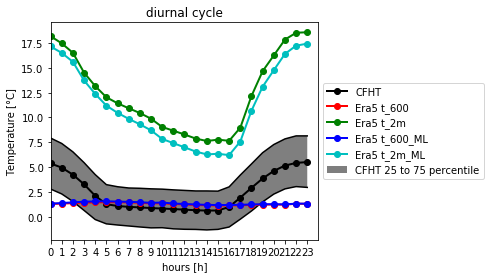

In [69]:
plot_cycle(diurnal_cycle_T2,'diurnal cycle', 'temperature(C)', 't', 
           'diurnal_cycle_UTC_T_2m_MK_ML_blank_600hPa_masked_2008to2012.pdf', 't_600', 't_2m','t_600_ML', 't_2m_ML')

/home/caroline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


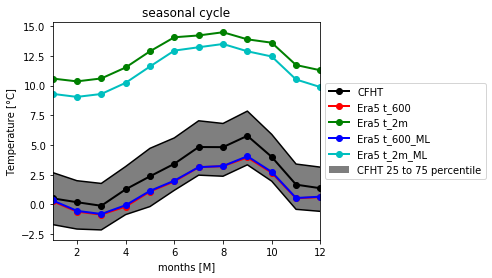

In [70]:
plot_cycle(seasonal_cycle_T2,'seasonal cycle', 'temperature(C)', 't',  
           'seasonal_cycle_UTC_T_2m_MK_ML_blank_600hPa_masked_2008to2012.pdf', 't_600', 't_2m', 't_600_ML', 't_2m_ML')

In [ ]:
################################ specific humidity ################################

In [11]:
# change current working directory
os.chdir('/home/haslebacher/chaldene/Astroclimate_Project')
# open NETCDF files on 600hPa to 750hPa

ds_SH = xr.open_mfdataset('sites/MaunaKea/Data/Era_5/SH/*.nc', combine = 'by_coords')
# open observational data from CFHT for Mauna Kea

CFHT_RH_hourly = pd.read_csv('./sites/MaunaKea/Data/in-situ/RH/downsampled_masked_RH_1991to2018_hourly_means.csv')#/home/caroline/chaldene/Astroclimate_Project/sites/MaunaKea/Data/in-situ/RH/

In [24]:
#open NETCDF files on different pressure levels for "relative humidity"
#ds_RH_600 = xr.open_mfdataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/RH/RH_600hPa/*.nc', combine = 'by_coords', parallel=True)
ds_SH_600 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_2008to2012_SH_600hPa.nc')
ds_SH_650 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_2008to2012_SH_650hPa.nc')
#observational data from MaunaKea (CFHT)
CFHT_SH_hourly = pd.read_csv('/home/caroline/Dropbox/Astroclimate Project/Mauna_Kea/CFHT/Specific_humidity/Specific_humidity_CFHT_masked_2000to2019.csv')


In [9]:
# for Mauna Kea
df_SH_600 = netcdf_to_df(ds_SH_600, 204.5, 19.75)
df_SH_650 = netcdf_to_df(ds_SH_650, 204.5, 19.75)
# and for Mauna Loa
df_SH_600_ML = netcdf_to_df(ds_SH_600, 204.5, 19.5)
df_SH_650_ML = netcdf_to_df(ds_SH_650, 204.5, 19.5)

df_prep_SH_600 = df_prep(df_SH_600, 'q', 'q_600')
df_prep_SH_650 = df_prep(df_SH_650, 'q', 'q_650')

df_prep_SH_600_ML = df_prep(df_SH_600_ML, 'q', 'q_600_ML')
df_prep_SH_650_ML = df_prep(df_SH_650_ML, 'q', 'q_650_ML')

In [27]:
CFHT_SH_hourly 

,Temp,P,RH,specific_humidity,months,hours
time,,,,,,
2000-01-01 10:00:00,-0.736667,612.560000,27.386667,0.001611,1,10
2000-01-01 11:00:00,-0.481667,612.330000,25.248333,0.001514,1,11
2000-01-01 12:00:00,-0.451667,611.941667,25.190000,0.001514,1,12
2000-01-01 13:00:00,-0.358333,611.471667,25.373333,0.001537,1,13
2000-01-01 14:00:00,-0.110000,611.638333,23.635000,0.001457,1,14
...,...,...,...,...,...,...
2020-01-17 08:00:00,-0.508500,614.150000,98.466667,0.005874,1,8
2020-01-17 09:00:00,-0.339333,614.043333,96.383333,0.005822,1,9
2020-01-17 10:00:00,-0.553333,613.805000,98.433333,0.005856,1,10


In [30]:
# do not shift specific humidity CFHT array by 10hours, it is already done! only add month and hours

CFHT_SH_hourly['time'] = pd.to_datetime(CFHT_SH_hourly['time']) 

#check the format
print(CFHT_SH_hourly['time'].dtype)
#print(CFHT_hourly['time'][0])
    
#set index 
CFHT_SH_hourly.set_index('time', inplace=True)

# create a new column consisting of the cycle parameter of the correspondend entry
#for seasonal cycle (12 months), create column with "months"
CFHT_SH_hourly['months'] = pd.DatetimeIndex(CFHT_SH_hourly.index).month                                            

#for diurnal cycle (24 hours), create column with "hours"
CFHT_SH_hourly['hours'] = pd.DatetimeIndex(CFHT_SH_hourly.index).hour

# for monthly timeseries, create column with "YYYY-MM"
#CFHT_hourly['YYYY_MM'] = pd.DatetimeIndex()
CFHT_hourly['YYYY_MM'] = CFHT_SH_hourly.index.strftime('%Y-%m')

# for 1 year averages, create column with years
CFHT_hourly['years'] = pd.DatetimeIndex(CFHT_hourly.index).year

KeyError: 'time'

In [33]:
# for monthly timeseries, create column with "YYYY-MM"
#CFHT_hourly['YYYY_MM'] = pd.DatetimeIndex()
CFHT_SH_hourly['YYYY_MM'] = CFHT_SH_hourly.index.strftime('%Y-%m')

# for 1 year averages, create column with years
CFHT_SH_hourly['years'] = pd.DatetimeIndex(CFHT_SH_hourly.index).year

In [34]:
CFHT_SH_hourly

,Temp,P,RH,specific_humidity,months,hours,YYYY_MM,years
time,,,,,,,,
2000-01-01 10:00:00,-0.736667,612.560000,27.386667,0.001611,1,10,2000-01,2000
2000-01-01 11:00:00,-0.481667,612.330000,25.248333,0.001514,1,11,2000-01,2000
2000-01-01 12:00:00,-0.451667,611.941667,25.190000,0.001514,1,12,2000-01,2000
2000-01-01 13:00:00,-0.358333,611.471667,25.373333,0.001537,1,13,2000-01,2000
2000-01-01 14:00:00,-0.110000,611.638333,23.635000,0.001457,1,14,2000-01,2000
...,...,...,...,...,...,...,...,...
2020-01-17 08:00:00,-0.508500,614.150000,98.466667,0.005874,1,8,2020-01,2020
2020-01-17 09:00:00,-0.339333,614.043333,96.383333,0.005822,1,9,2020-01,2020
2020-01-17 10:00:00,-0.553333,613.805000,98.433333,0.005856,1,10,2020-01,2020


In [35]:
test = CFHT_SH_hourly.groupby('YYYY_MM').describe()

In [37]:
test['specific_humidity']

,count,mean,std,min,25%,50%,75%,max
YYYY_MM,,,,,,,,
2000-01,732.0,0.001918,0.001492,0.000110,0.000636,0.001517,0.002986,0.005859
2000-02,684.0,0.001680,0.001255,0.000211,0.000638,0.001362,0.002185,0.005739
2000-03,741.0,0.001649,0.001300,0.000138,0.000650,0.001160,0.002404,0.005550
2000-04,718.0,0.001240,0.001085,0.000056,0.000482,0.000909,0.001673,0.006004
2000-05,744.0,0.002210,0.001380,0.000261,0.000956,0.001970,0.003257,0.005807
...,...,...,...,...,...,...,...,...
2019-09,720.0,0.004517,0.002229,0.000564,0.002474,0.004618,0.006319,0.009086
2019-10,744.0,0.002880,0.001995,0.000423,0.001196,0.002273,0.004068,0.007615
2019-11,720.0,0.003097,0.001710,0.000389,0.001665,0.002801,0.004518,0.007467


In [23]:
CFHT_SH_hourly.index

Index(['2000-01-01 10:00:00', '2000-01-01 11:00:00', '2000-01-01 12:00:00',
       '2000-01-01 13:00:00', '2000-01-01 14:00:00', '2000-01-01 15:00:00',
       '2000-01-01 16:00:00', '2000-01-01 17:00:00', '2000-01-01 18:00:00',
       '2000-01-01 19:00:00',
       ...
       '2020-01-17 03:00:00', '2020-01-17 04:00:00', '2020-01-17 05:00:00',
       '2020-01-17 06:00:00', '2020-01-17 07:00:00', '2020-01-17 08:00:00',
       '2020-01-17 09:00:00', '2020-01-17 10:00:00', '2020-01-17 11:00:00',
       '2020-01-17 12:00:00'],
      dtype='object', name='time', length=169567)

In [16]:
seasonal_cycle_SH, diurnal_cycle_SH, df_merged_SH = merge_df(CFHT_SH_hourly, df_prep_SH_600, df_prep_SH_650,
                                              df_prep_SH_600_ML, df_prep_SH_650_ML)

/home/caroline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


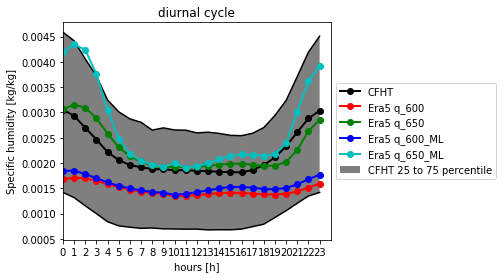

In [13]:
plot_cycle(diurnal_cycle_SH,'diurnal cycle', 'specific_humidity', 'q',  'diurnal_cycle_UTC_SH_MK_ML_blank_masked_2008to2012.pdf',
           'q_600', 'q_650', 'q_600_ML', 'q_650_ML')

/home/caroline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


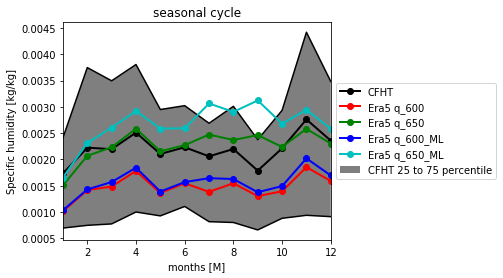

In [68]:
plot_cycle(seasonal_cycle_SH,'seasonal cycle', 'specific_humidity', 'q',  'seasonal_cycle_UTC_SH_MK_ML_blank_masked_2008to2012.pdf', 
           'q_600', 'q_650', 'q_600_ML', 'q_650_ML')

In [17]:
df_merged_SH

,Temp,P,RH,specific_humidity,months,hours,q_600,q_650,q_600_ML,q_650_ML
time,,,,,,,,,,
2008-01-01 09:00:00,-0.520000,612.800000,84.000000,0.005018,1.0,9.0,0.003585,0.004403,0.003728,0.004635
2008-01-01 10:00:00,-0.335833,612.516667,77.166667,0.004674,1.0,10.0,0.003039,0.003791,0.003048,0.004597
2008-01-01 11:00:00,-0.028333,612.100000,68.250000,0.004230,1.0,11.0,0.002920,0.003579,0.002918,0.004261
2008-01-01 12:00:00,-0.277500,611.708333,66.083333,0.004025,1.0,12.0,0.002880,0.003409,0.002943,0.003855
2008-01-01 13:00:00,-1.401667,611.425000,80.583333,0.004523,1.0,13.0,0.002889,0.003428,0.002991,0.003923
...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,7.910000,619.035000,6.450000,0.000691,12.0,19.0,0.000309,0.000866,0.000416,0.001451
2012-12-31 20:00:00,8.326833,618.978333,6.100000,0.000672,12.0,20.0,0.000310,0.000720,0.000361,0.001241
2012-12-31 21:00:00,8.947500,618.490000,7.350000,0.000846,12.0,21.0,0.000331,0.000627,0.000331,0.001066


In [178]:
#open NETCDF files on different pressure levels for "specific humidity"
#ds_RH_600 = xr.open_mfdataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/RH/RH_600hPa/*.nc', combine = 'by_coords', parallel=True)
ds_SH_600_1 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_2008to2012_SH_600hPa.nc')

# for long timeseries (1979 to 2018)
ds_SH_600_2 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_2013to2016_SH_600hPa.nc')
ds_SH_600_3 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_2017to2018_SH_600hPa.nc')
ds_SH_600_4 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_2004to2007_SH_600hPa.nc')
ds_SH_600_5 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_1998to2003_SH_600hPa.nc')
ds_SH_600_6 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_1993to1997_SH_600hPa.nc')
ds_SH_600_7 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_1993to1997_SH_600hPa.nc')
ds_SH_600_8 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_1993to1997_SH_600hPa.nc')
ds_SH_600_9 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_1987to1992_SH_600hPa.nc')
ds_SH_600_10 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_1983to1986_SH_600hPa.nc')
ds_SH_600_11 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_1979to1982_SH_600hPa.nc')

#ds_SH_650 = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/SH/Era5_2008to2012_SH_650hPa.nc')
#observational data from MaunaKea (CFHT)
CFHT_SH_hourly = pd.read_csv('/home/caroline/Dropbox/Astroclimate Project/Mauna_Kea/CFHT/Specific_humidity/Specific_humidity_CFHT_masked_2000to2019.csv')


In [4]:
# calculate precipitable water for 2017-03-01 and compare to Total column water from single level dataset
import os
os.chdir('/home/haslebacher/chaldene/')


# Total column water for 2008 to 2012
ds_TWC_value = xr.open_dataset('./cds_data_ERA5/Era5_single_level_2008to2012_TotalColumnWater.nc')

# specific humidity for all pressure levels, for one date
ds_specific_hum = xr.open_dataset('./cds_data_ERA5/Era5_2010_march_01_PWV_test_all_pressure_levels.nc')



In [5]:
# select time and/or place (lon = 204.5, lat = 19.75)

ds_specific_hum_MK = ds_specific_hum.sel(longitude=204.53,latitude= 19.83,method='nearest')

ds_TWC_value_MK = ds_TWC_value.sel(longitude=204.53,latitude= 19.83,method='nearest')
ds_TWC_value_MK_2010 = ds_TWC_value_MK.sel(time='2010-03-01T10:00:00')


In [7]:
TCW_2010 = ds_TWC_value_MK_2010.tcw
TCW_2010

<xarray.DataArray 'tcw' ()>
array(8.396564, dtype=float32)
Coordinates:
    longitude  float32 204.5
    latitude   float32 19.75
    time       datetime64[ns] 2010-03-01T10:00:00
Attributes:
    units:      kg m**-2
    long_name:  Total column water

In [16]:
# ds_specific_hum_MK.q[0, 36] gives you the value of the specific humidity at time index 0 (meaning 2010-03-01) and on pressure level 36 (= 1000hPa)
ds_specific_hum_MK.q#[0, 36]

<xarray.DataArray 'q' (time: 1, level: 37)>
array([[3.729016e-06, 3.384426e-06, 3.384426e-06, 3.384426e-06, 3.040768e-06,
        3.040768e-06, 3.040768e-06, 2.696179e-06, 2.696179e-06, 2.352521e-06,
        2.352521e-06, 4.417263e-06, 1.233350e-05, 1.680758e-05, 3.780238e-05,
        8.289050e-05, 1.441548e-04, 6.636977e-05, 8.392334e-05, 2.983483e-04,
        4.735375e-04, 3.737248e-04, 1.685917e-04, 9.975582e-05, 1.244161e-03,
        3.983507e-03, 6.918692e-03, 7.778803e-03, 7.919573e-03, 7.953648e-03,
        8.010093e-03, 8.060688e-03, 8.086502e-03, 8.086502e-03, 8.086502e-03,
        8.086502e-03, 8.086502e-03]], dtype=float32)
Coordinates:
    longitude  float32 204.5
    latitude   float32 19.75
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2010-03-01T10:00:00
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity

In [224]:
ds_specific_hum_MK.level[36]  - ds_specific_hum_MK.level[35] 

<xarray.DataArray 'level' ()>
array(25, dtype=int32)
Coordinates:
    longitude  float32 204.5
    latitude   float32 19.75

In [229]:
ds_specific_hum_MK.level[27]

<xarray.DataArray 'level' ()>
array(775, dtype=int32)
Coordinates:
    longitude  float32 204.5
    latitude   float32 19.75
    level      int32 775
Attributes:
    units:      millibars
    long_name:  pressure_level

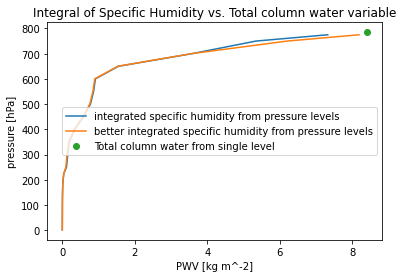

In [15]:
# integrate over specific humidity
sum = 0
sum2 = 0
PWV = []
PWV2 = []
for i in range(0, 28):
    delta_p = 100 * (ds_specific_hum_MK.level[int(i+1)]  - ds_specific_hum_MK.level[i]) # * 100 for transformation from milibar to Pa
    #print('delta_p1 is {}'.format(delta_p))

    #better delta_p
    if i == 0:
        delta_p2 = 100
    elif i == 27:
        delta_p2 = 2500
    else:
        delta_p2 = 100 * 0.5 * (ds_specific_hum_MK.level[int(i+1)] - ds_specific_hum_MK.level[int(i-1)])
        #print('delta_p2 is {}'.format(delta_p2))

    #print(delta_p, i, '\n')
    sum = sum + delta_p * ds_specific_hum_MK.q[0, i]
    sum2 = sum2 + delta_p2 * ds_specific_hum_MK.q[0, i]
    PWV.append(sum/9.81)
    PWV2.append(sum2/9.81)
    #print(sum/9.81) # PWV = 1/g * sum(delta_p * q)
plt.plot(PWV, ds_specific_hum_MK.level[0:28], label = 'integrated specific humidity from pressure levels')
plt.plot(PWV2, ds_specific_hum_MK.level[0:28], label = 'better integrated specific humidity from pressure levels')
plt.ylabel('pressure [hPa]')
plt.xlabel('PWV [kg m^-2]')
plt.plot(TCW_2010, 785, 'o', label = 'Total column water from single level')
plt.legend()
plt.title('Integral of Specific Humidity vs. Total column water variable')
plt.savefig('./Astroclimate_Project/sites/MaunaKea/Output/Plots/TCW/Spec_Hum_integral_vs_TWC_single_level_best_int.pdf')
plt.show()

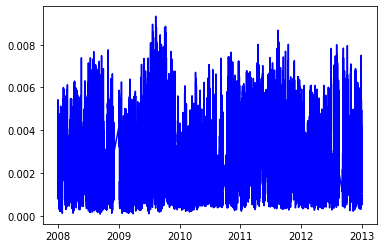

In [22]:
# plot timeseries


plt.plot(df_merged_SH.index, df_merged_SH['specific_humidity'] , c='blue', markersize = '2')
plt.show()

################################### PRESSURE ################################

In [31]:
# timeseries of pressure from CFHT and surface pressure

# open data
ds_SP = xr.open_dataset('/home/caroline/chaldene/cds_data_ERA5/Era5_single_level_2008to2012_surface_pressure.nc')

#observational data from MaunaKea (CFHT)
CFHT_P_hourly = pd.read_csv('/home/caroline/Dropbox/Astroclimate Project/Mauna_Kea/CFHT/pressure/downsampled_Pressure_hourly.csv')


In [120]:
CFHT_P_hourly_preped = mes_prep(CFHT_P_hourly, 'pressure (mb)')

datetime64[ns]


In [32]:
df_SP = netcdf_to_df(ds_SP, 204.5, 19.75)
df_SP_ML = netcdf_to_df(ds_SP, 204.5, 19.5) #Mauna Loa

In [39]:
df_prep_SP = df_prep(df_SP, 'sp', 'sp')
df_prep_SP_ML = df_prep(df_SP_ML, 'sp', 'sp_ML') # Mauna Loa

In [80]:
# only execute once! to convert pressure to hPa
df_prep_SP = df_prep_SP/100
df_prep_SP_ML = df_prep_SP_ML/100

In [121]:

merged_df_Press, seasonal_P, diurnal_P, monthly_grouped_P, yearly_grouped_P  = merge_df(CFHT_P_hourly_preped, df_prep_SP, df_prep_SP_ML)

In [147]:
yearly_grouped_P

pressure (mb)                                                \
               count        mean       std         min         25%   
years                                                                
2008.0        8015.0  615.870738  2.079312  608.266667  614.533333   
2009.0        8712.0  615.875829  2.601719  603.666667  614.435606   
2010.0        8352.0  617.474038  1.993552  610.253333  616.072500   
2011.0        8735.0  616.891285  2.045118  605.601667  615.790833   
2012.0        8325.0  616.923018  1.824895  609.178333  615.851667   

                                            months            ...          sp  \
               50%         75%         max   count      mean  ...         75%   
years                                                         ...               
2008.0  616.075000  617.383333  622.375000  8015.0  6.030069  ...  789.284424   
2009.0  616.358333  617.725000  621.243333  8712.0  6.538797  ...  788.670288   
2010.0  617.833333  618.993333  622.360000  8352.0  6.383381  ...  789.474121   
2011.0  617.170000  618.268333  621.570000  8735.0  6.512078  ...  789.302490   
2012.0  617.128333  618.153333  621.846667  8325.0  6.419099  ...  789.076721   

                     sp_ML                                                \
               max   count        mean       std         min         25%   
years                                                                      
2008.0  792.689392  8015.0  763.631287  1.418854  758.693970  762.704041   
2009.0  792.572021  8712.0  762.898682  1.655718  754.232361  761.954468   
2010.0  793.041626  8352.0  763.631042  1.642567  758.025696  762.595703   
2011.0  792.165527  8735.0  763.476196  1.667584  755.758667  762.514465   
2012.0  793.014526  8325.0  763.362732  1.551884  757.339294  762.378967   

                                            
               50%         75%         max  
years                                       
2008.0  763.670471  764.591736  768.059937  
2009.0  763.065369  764.031799  767.635376  
2010.0  763.760803  764.763367  768.592834  
2011.0  763.607239  764.618835  767.572205  
2012.0  763.390564  764.356873  768.394043  

[5 rows x 40 columns]

In [164]:

yearly_grouped_P

pressure (mb)                                                            \
             count        mean       std         min         25%         50%   
2008        8015.0  615.870738  2.079312  608.266667  614.533333  616.075000   
2009        8712.0  615.875829  2.601719  603.666667  614.435606  616.358333   
2010        8352.0  617.474038  1.993552  610.253333  616.072500  617.833333   
2011        8735.0  616.891285  2.045118  605.601667  615.790833  617.170000   
2012        8325.0  616.923018  1.824895  609.178333  615.851667  617.128333   

                              months            ...          sp              \
             75%         max   count      mean  ...         75%         max   
2008  617.383333  622.375000  8015.0  6.030069  ...  789.284424  792.689392   
2009  617.725000  621.243333  8712.0  6.538797  ...  788.670288  792.572021   
2010  618.993333  622.360000  8352.0  6.383381  ...  789.474121  793.041626   
2011  618.268333  621.570000  8735.0  6.512078  ...  789.302490  792.165527   
2012  618.153333  621.846667  8325.0  6.419099  ...  789.076721  793.014526   

       sp_ML                                                            \
       count        mean       std         min         25%         50%   
2008  8015.0  763.631287  1.418854  758.693970  762.704041  763.670471   
2009  8712.0  762.898682  1.655718  754.232361  761.954468  763.065369   
2010  8352.0  763.631042  1.642567  758.025696  762.595703  763.760803   
2011  8735.0  763.476196  1.667584  755.758667  762.514465  763.607239   
2012  8325.0  763.362732  1.551884  757.339294  762.378967  763.390564   

                              
             75%         max  
2008  764.591736  768.059937  
2009  764.031799  767.635376  
2010  764.763367  768.592834  
2011  764.618835  767.572205  
2012  764.356873  768.394043  

[5 rows x 40 columns]

In [161]:
pd.to_datetime(yearly_grouped_P.index.astype(int), format = '%Y')


DatetimeIndex(['2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01'],
              dtype='datetime64[ns]', freq=None)

In [174]:
def plot_timeseries(filename,merged_df, monthly_grouped_P, yearly_grouped_P, *args):
    # this function plots timeseries for variable input datasets (output from function "merge_df()")
    # it saves the file to the current path of this notebook under the chosen filename
    # you have to name the args in a way that they serve as a label at the same time
    # define color cycle
    # it assumes that the first args is the in-situ measurement and plots it in black
    cycol = cycle('krgbcm')
    for ar in args:  # e.g. args = 'sp'
        my_col =next(cycol)
        #plt.plot(cycle_name.index, cycle_name[ar]['mean'], '-o', c= my_col, linewidth=2.0, 
         #   label = 'Era5 ' + ar)
        plt.plot(merged_df.index, merged_df[ar], c=my_col, markersize = '1', label = 'hourly ,' + ar, alpha = 0.5)
        plt.plot(pd.to_datetime(monthly_grouped_P.index) , monthly_grouped_P[ar]['mean'], '-o',c=my_col,  label = 'monthly ' + ar, markersize = '2')
        if 'sp' in ar:
            plt.ylabel('Pressure [hPa]')
        elif 'q' in ar:
            plt.ylabel('Specific Humidity [kg/kg]')
        elif 'temperature' in ar:
            plt.ylabel('Temperature [°C]')

    #plt.plot(pd.to_datetime(yearly_grouped_P.index.astype(int), format = '%Y'), yearly_grouped_P['pressure (mb)']['mean'], c='black', markersize = '2', label = 'CFHT yearly')
    plt.xlabel('time [years]')
    plt.legend()
    fig1 = plt.gcf()
    fig1.savefig(filename)
    plt.show()

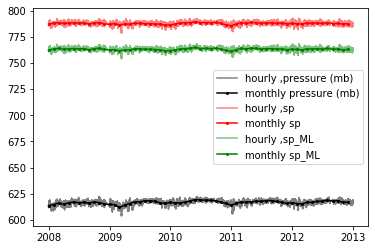

In [173]:
plot_timeseries('test.pdf', merged_df_Press, monthly_grouped_P, yearly_grouped_P, 'pressure (mb)', 'sp', 'sp_ML')

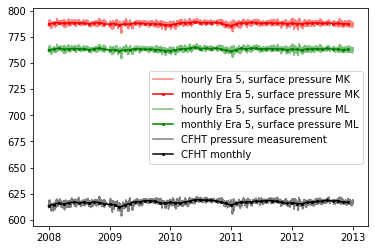

In [169]:
# plot timeseries

# ERA 5, Mauna Kea location, surface pressure
plt.plot(merged_df_Press.index, merged_df_Press['sp'], c='red', markersize = '1', label = 'hourly Era 5, surface pressure MK', alpha = 0.5)
plt.plot(pd.to_datetime(monthly_grouped_P.index) , monthly_grouped_P['sp']['mean'], '-ro',  label = 'monthly Era 5, surface pressure MK', markersize = '2')

# ERA 5, Mauna Loa location, surface pressure
plt.plot(merged_df_Press.index, merged_df_Press['sp_ML'], c='green', markersize = '1', label = 'hourly Era 5, surface pressure ML', alpha = 0.5)
plt.plot(pd.to_datetime(monthly_grouped_P.index) , monthly_grouped_P['sp_ML']['mean'], '-go',  label = 'monthly Era 5, surface pressure ML', markersize = '2')

# CFHT measurements
plt.plot(merged_df_Press.index, merged_df_Press['pressure (mb)'], c='black', markersize = '1', label = 'CFHT pressure measurement', alpha = 0.5)
#plt.plot(pd.to_datetime(yearly_grouped_P.index.astype(int), format = '%Y'), yearly_grouped_P['pressure (mb)']['mean'], c='black', markersize = '2', label = 'CFHT yearly')

plt.plot(pd.to_datetime(monthly_grouped_P.index) , monthly_grouped_P['pressure (mb)']['mean'], '-ko',  label = 'CFHT monthly', markersize = '2')
plt.legend()
fig1 = plt.gcf()
fig1.savefig('timeseries_UTC_P_MK_ML_2008to2012.pdf')
plt.show()

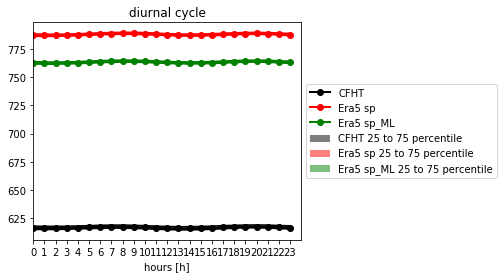

In [86]:
plot_cycle(diurnal_P,'diurnal cycle', 'pressure (mb)', 'diurnal_cycle_UTC_P_MK_ML_2008to2012.pdf', 
           'sp', 'sp_ML')

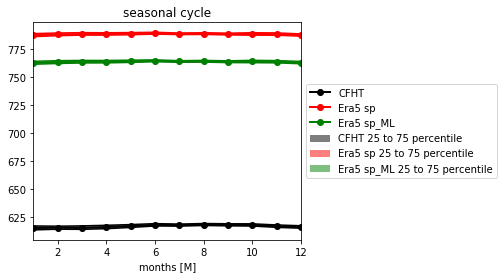

In [87]:
plot_cycle(seasonal_P,'seasonal cycle', 'pressure (mb)', 'seasonal_cycle_UTC_P_MK_ML_2008to2012.pdf', 
           'sp', 'sp_ML')

In [ ]:
################## rubbish ########################

In [134]:
CFHT_hourly = CFHT_hourly.rename(columns={'Unnamed: 0': 'time'})
# change the format of the times column to datetime format
CFHT_hourly['time'] = pd.to_datetime(CFHT_hourly['time']) 

#check the format
print(CFHT_hourly['time'].dtype)
print(CFHT_hourly['time'][0])


datetime64[ns]
1992-03-13 21:00:00


In [142]:
CFHT_hourly['time']
# or whatever value you want
CFHT_hourly['time'] = CFHT_hourly['time'] + dt.timedelta(hours=10)

In [143]:
CFHT_hourly

,time,relative_humidity(%)
0,1992-03-14 07:00:00,15.600000
1,1992-03-14 08:00:00,13.938333
2,1992-03-14 09:00:00,14.846667
3,1992-03-14 10:00:00,14.905000
4,1992-03-14 11:00:00,NaN
...,...,...
264784,2020-01-17 08:00:00,98.466667
264785,2020-01-17 09:00:00,96.383333
264786,2020-01-17 10:00:00,98.433333
264787,2020-01-17 11:00:00,98.350000


In [140]:
ten_later

0        1992-03-14 07:00:00
1        1992-03-14 08:00:00
2        1992-03-14 09:00:00
3        1992-03-14 10:00:00
4        1992-03-14 11:00:00
                 ...        
264784   2020-01-17 08:00:00
264785   2020-01-17 09:00:00
264786   2020-01-17 10:00:00
264787   2020-01-17 11:00:00
264788   2020-01-17 12:00:00
Name: time, Length: 264789, dtype: datetime64[ns]

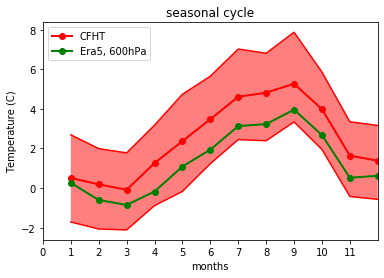

In [82]:
# seasonal cycle
# plot seasonal cycle observational data and also show quartiles
#def plot_cycle(cycle, CFHT_parameter, Era5_1)
plt.plot(seasonal_cycle.index, seasonal_cycle['temperature(C)']['mean'], '-ro', linewidth=2.0, 
        label = 'CFHT')
plt.plot(seasonal_cycle.index, seasonal_cycle['temperature(C)']['75%'], color='r')
plt.plot(seasonal_cycle.index, seasonal_cycle['temperature(C)']['25%'], color='r')
plt.fill_between(seasonal_cycle.index, seasonal_cycle['temperature(C)']['mean'], seasonal_cycle['temperature(C)']['75%'], alpha=.5, facecolor='r')
plt.fill_between(seasonal_cycle.index, seasonal_cycle['temperature(C)']['mean'], seasonal_cycle['temperature(C)']['25%'], alpha=.5, facecolor='r')

plt.plot(seasonal_cycle.index, seasonal_cycle['t_600']['mean'], '-go', linewidth=2.0, 
        label = 'Era5, 600hPa')

#plt.plot(diurnal_cycle.index, diurnal_cycle['r_600']['75%'], color='b')
#plt.plot(diurnal_cycle.index, diurnal_cycle['r_600']['25%'], color='b')
#plt.fill_between(diurnal_cycle.index, diurnal_cycle['r_600']['mean'], diurnal_cycle['r_600']['75%'], alpha=.5, facecolor='b')
#plt.fill_between(diurnal_cycle.index, diurnal_cycle['r_600']['mean'], diurnal_cycle['r_600']['25%'], alpha=.5, facecolor='b')

#plt.plot(diurnal_cycle.index, diurnal_cycle['r_750']['mean'], '-go', linewidth=2.0, 
#        label = 'Era5, 750hPa')
plt.legend()
#plt.ylim(0, 100)
plt.xlim(0, 12)
plt.xticks(np.arange(0, 12, step=1))
plt.xlabel('months')
plt.ylabel('Temperature (C)')
plt.title('seasonal cycle')
fig1 = plt.gcf()
fig1.savefig('seasonal_cycle_T_2008to2012.pdf')
plt.show()

In [178]:
ds_MaunaKea_RH_600 = ds_RH_600.sel(longitude=204.53,latitude= 19.83,method='nearest')
ds_MaunaKea_RH_600_time = ds_MaunaKea_RH_600.sel(time=slice('2008-01-01', '2012-12-31'))
#ds_MaunaKea_RH_600_loc = ds_RH_600.loc['2008-01-01':'2012-01-02']

In [188]:

seasonal_cycle_MK = ds_MaunaKea_RH_600_time.groupby('time.month')


DatasetGroupBy, grouped over 'month' 
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [154]:
CFHT_hourly['relative_humidity(%)']

time
1992-03-13 21:00:00    15.600000
1992-03-13 22:00:00    13.938333
1992-03-13 23:00:00    14.846667
1992-03-14 00:00:00    14.905000
1992-03-14 01:00:00          NaN
                         ...    
2020-01-16 22:00:00    98.466667
2020-01-16 23:00:00    96.383333
2020-01-17 00:00:00    98.433333
2020-01-17 01:00:00    98.350000
2020-01-17 02:00:00    94.535714
Name: relative_humidity(%), Length: 264789, dtype: float64

In [183]:

df_RH_600 = ds_MaunaKea_RH_600_time.to_dask_dataframe() #


In [10]:
df_RH_600.known_divisions

True

In [11]:
#df_RH_600.npartitions
df_RH_600.divisions#loc['2010-01-20': '2010-02-10'] 

(0, 43847)

In [74]:
df_RH_650_comp = df_RH_650.set_index('time')
df_RH_650_comp
df_RH_650_drop = df_RH_650_comp.drop('latitude', axis=1)
df_RH_650_drop = df_RH_650_drop.drop('longitude', axis=1)
df_RH_650_drop

ValueError: Metadata inference failed in `drop_by_shallow_copy`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
KeyError("[('longitude', 'latitude')] not found in axis")

Traceback:
---------
  File "/home/caroline/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py", line 173, in raise_on_meta_error
    yield
  File "/home/caroline/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py", line 4888, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/home/caroline/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py", line 967, in drop_by_shallow_copy
    df2.drop(columns=columns, inplace=True, errors=errors)
  File "/home/caroline/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py", line 3994, in drop
    errors=errors,
  File "/home/caroline/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 3935, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/home/caroline/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 3969, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
  File "/home/caroline/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 5018, in drop
    raise KeyError(f"{labels[mask]} not found in axis")


In [59]:
df_RH_650_comp_renamed = df_RH_650_comp.rename(columns={'r': 'r_650'})

In [65]:
df_RH_650_comp


,latitude,longitude,r
time,,,
2008-01-01 00:00:00,19.75,204.5,93.771881
2008-01-01 01:00:00,19.75,204.5,94.542542
2008-01-01 02:00:00,19.75,204.5,95.235123
2008-01-01 03:00:00,19.75,204.5,91.938583
2008-01-01 04:00:00,19.75,204.5,92.138893
...,...,...,...
2012-12-31 19:00:00,19.75,204.5,11.114128
2012-12-31 20:00:00,19.75,204.5,9.121269
2012-12-31 21:00:00,19.75,204.5,7.916046


In [85]:
df_RH_650.compute()

,time,r
0,2008-01-01 00:00:00,93.771881
1,2008-01-01 01:00:00,94.542542
2,2008-01-01 02:00:00,95.235123
3,2008-01-01 03:00:00,91.938583
4,2008-01-01 04:00:00,92.138893
...,...,...
43843,2012-12-31 19:00:00,11.114128
43844,2012-12-31 20:00:00,9.121269
43845,2012-12-31 21:00:00,7.916046
43846,2012-12-31 22:00:00,7.196312


In [7]:
df_RH_600.head(1)

NameError: name 'df_RH_600' is not defined

In [8]:
#delete lon and lat columns
df_RH_600 = df_RH_600.drop('longitude', axis=1)
df_RH_600 = df_RH_600.drop('latitude', axis=1)

df_RH_650 = df_RH_650.drop('longitude', axis=1)
df_RH_650 = df_RH_650.drop('latitude', axis=1)

#df_RH_700 = df_RH_700.drop('longitude', axis=1)
#df_RH_700 = df_RH_700.drop('latitude', axis=1)

# for plotting set an index for merging
df_RH_600 = df_RH_600.set_index('time')
df_RH_650 = df_RH_650.set_index('time')
#df_RH_700 = df_RH_700.set_index('time')

# rename columns for better overview
df_RH_600 = df_RH_600.rename(columns={'r': 'r_600'})
df_RH_650 = df_RH_650.rename(columns={'r': 'r_650'})
#df_RH_700 = df_RH_700.rename(columns={'r': 'r_700'})

# convert dask dataframe to pandas output (compute) for plotting?
df_RH_600_comp = df_RH_600.compute()
df_RH_650_comp= df_RH_650.compute()

NameError: name 'df_RH_600' is not defined

In [39]:
df_RH_750 = df_RH_750.drop('longitude', axis=1)
df_RH_750 = df_RH_750.drop('latitude', axis=1)
df_RH_750 = df_RH_750.set_index('time')
df_RH_750 = df_RH_750.rename(columns={'r': 'r_750'})
df_RH_750_comp= df_RH_750.compute()

In [45]:
df_RH_700 

,r_700
npartitions=1,
2008-01-01 00:00:00,float32
2012-12-31 23:00:00,...


In [41]:
df_RH_750 = df_RH_750.rename(columns={'r_650': 'r_750'})

In [22]:
df_RH_600 = df_RH_600.rename(columns={'r_650': 'r_600'})
df_RH_600_comp = df_RH_600.compute()
df_RH_650_comp= df_RH_650.compute()

In [23]:
df_RH_600

,r_600
npartitions=1,
2008-01-01 00:00:00,float32
2012-12-31 23:00:00,...


In [48]:
# now try to merge datasets to only compare equal rows of data


df_list = [CFHT_hourly, df_RH_600_comp['r_600'], df_RH_650_comp['r_650'], df_RH_700_comp['r_700'], df_RH_750_comp['r_750']] #, df3, ..., df_n], drop lon and lat
df_merged = reduce(lambda left, right: pd.merge(left, right, left_on='time', right_on='time', how='outer'), df_list)

# delete rows containing NaN
df_merged_nonan = df_merged.dropna(axis='rows', how='any', thresh=None, subset=None, inplace=False)

# reduce to seasonal cycle
seasonal_cycle = df_merged_nonan.groupby('months').describe()

# reduce to seasonal cycle
diurnal_cycle = df_merged_nonan.groupby('hours').describe()


In [49]:
# plot the diurnal and the seasonal cycle

seasonal_cycle

relative_humidity(%)                                             \
                      count       mean        std       min        25%   
months                                                                   
1.0                  3709.0  29.187317  27.509834  2.083333  10.200000   
2.0                  3394.0  37.405202  31.397510  2.166667  11.000000   
3.0                  3717.0  37.889170  31.483352  1.333333  11.650000   
4.0                  3599.0  38.619992  28.426236  2.000000  14.083333   
5.0                  3720.0  31.071249  26.532557  2.916667  11.995833   
6.0                  3599.0  29.646489  20.338012  1.000000  13.566667   
7.0                  3707.0  25.398418  24.311987  2.000000   9.400000   
8.0                  3331.0  25.658888  23.234445  2.000000   9.066667   
9.0                  3258.0  19.830062  19.422573  1.000000   7.016667   
10.0                 3541.0  27.910673  23.343196  3.000000  10.466667   
11.0                 3549.0  42.123165  32.410262  2.000000  12.933333   
12.0                 3018.0  36.236491  31.026086  4.116667  12.450000   

                                      hours             ...      r_700  \
              50%        75%    max   count       mean  ...        75%   
months                                                  ...              
1.0     17.433333  37.133333  100.0  3709.0  11.522513  ...  54.768875   
2.0     25.041667  60.050000  100.0  3394.0  11.525928  ...  70.105524   
3.0     26.333333  61.416667  100.0  3717.0  11.496368  ...  72.048454   
4.0     30.500000  57.341667  100.0  3599.0  11.499583  ...  73.430550   
5.0     20.583333  41.833333  100.0  3720.0  11.500000  ...  66.343916   
6.0     24.583333  40.233333  100.0  3599.0  11.498472  ...  56.663300   
7.0     14.833333  33.191667  100.0  3707.0  11.507688  ...  64.104820   
8.0     14.766667  36.166667  100.0  3331.0  11.482738  ...  59.018986   
9.0     11.983333  25.495833  100.0  3258.0  11.522713  ...  66.506460   
10.0    20.333333  36.483333  100.0  3541.0  11.521604  ...  61.720196   
11.0    30.750000  70.216667  100.0  3549.0  11.517611  ...  69.890213   
12.0    23.333333  52.650000  100.0  3018.0  11.516236  ...  69.736172   

                     r_750                                             \
               max   count       mean        std       min        25%   
months                                                                  
1.0     102.730263  3709.0  52.967617  23.757774  2.410217  33.409039   
2.0     104.789787  3394.0  61.385483  22.991529  4.681984  44.595050   
3.0     107.713966  3717.0  61.199593  21.588545  5.869972  45.573750   
4.0     107.390572  3599.0  64.011086  21.164112  5.755341  49.092552   
5.0     105.385513  3720.0  57.293606  22.301308  6.693230  39.065871   
6.0     105.116585  3599.0  51.376297  20.091671  4.119255  36.604794   
7.0     104.275757  3707.0  54.688622  19.266472  8.332787  40.111439   
8.0     105.252754  3331.0  52.564922  19.776760  7.242065  38.266933   
9.0     101.766876  3258.0  56.723434  19.297806  7.464378  42.427492   
10.0    101.814537  3541.0  55.310017  21.861462  1.736336  38.084568   
11.0    108.806709  3549.0  61.724323  21.032074  5.414925  46.122585   
12.0    102.454521  3018.0  61.325142  22.424927  0.829712  45.012753   

                                          
              50%        75%         max  
months                                    
1.0     52.347359  72.758499  108.144539  
2.0     63.773918  80.372738  104.201950  
3.0     62.254196  79.080536  104.493736  
4.0     65.269325  81.067467  106.501503  
5.0     56.840519  74.759327  106.126350  
6.0     50.561905  65.503796  101.805130  
7.0     53.528397  69.178913  101.985764  
8.0     52.135468  67.032196  105.146782  
9.0     56.515734  71.331701   97.949387  
10.0    56.001633  72.192299  102.378288  
11.0    64.609329  78.302444  105.271835  
12.0    62.832561  79.145670  106.855812  

[12 rows x 48 columns]

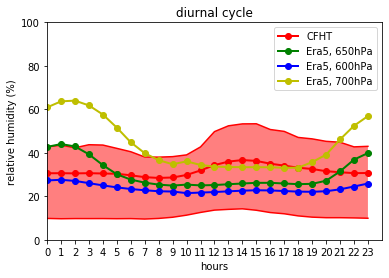

In [55]:
# plot seasonal cycle observational data and also show quartiles

plt.plot(diurnal_cycle.index, diurnal_cycle['relative_humidity(%)']['mean'], '-ro', linewidth=2.0, 
        label = 'CFHT')
plt.plot(diurnal_cycle.index, diurnal_cycle['relative_humidity(%)']['75%'], color='r')
plt.plot(diurnal_cycle.index, diurnal_cycle['relative_humidity(%)']['25%'], color='r')
plt.fill_between(diurnal_cycle.index, diurnal_cycle['relative_humidity(%)']['mean'], diurnal_cycle['relative_humidity(%)']['75%'], alpha=.5, facecolor='r')
plt.fill_between(diurnal_cycle.index, diurnal_cycle['relative_humidity(%)']['mean'], diurnal_cycle['relative_humidity(%)']['25%'], alpha=.5, facecolor='r')

plt.plot(diurnal_cycle.index, diurnal_cycle['r_650']['mean'], '-go', linewidth=2.0, 
        label = 'Era5, 650hPa')
plt.plot(diurnal_cycle.index, diurnal_cycle['r_600']['mean'], '-bo', linewidth=2.0, 
        label = 'Era5, 600hPa')
#plt.plot(diurnal_cycle.index, diurnal_cycle['r_600']['75%'], color='b')
#plt.plot(diurnal_cycle.index, diurnal_cycle['r_600']['25%'], color='b')
#plt.fill_between(diurnal_cycle.index, diurnal_cycle['r_600']['mean'], diurnal_cycle['r_600']['75%'], alpha=.5, facecolor='b')
#plt.fill_between(diurnal_cycle.index, diurnal_cycle['r_600']['mean'], diurnal_cycle['r_600']['25%'], alpha=.5, facecolor='b')
plt.plot(diurnal_cycle.index, diurnal_cycle['r_700']['mean'], '-yo', linewidth=2.0, 
        label = 'Era5, 700hPa')
#plt.plot(diurnal_cycle.index, diurnal_cycle['r_750']['mean'], '-go', linewidth=2.0, 
#        label = 'Era5, 750hPa')
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('hours')
plt.ylabel('relative humidity (%)')
plt.title('diurnal cycle')
fig1 = plt.gcf()
fig1.savefig('diurnal_cycle_RH_2008to2012.pdf')
plt.show()